# Advanced Machine Learning Project: fruit detection
##  Part 1: Feed Forward Neural Network

In this part, we want to train a FFN to recognize the image, to better clarify what are the advantages in using CNN.

In [ ]:
!pip install split-folders

In [ ]:
#Librerie utili

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import splitfolders
import os

from PIL import Image

from keras import Input, Model, Sequential, optimizers, losses, metrics, regularizers
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.experimental.preprocessing import Resizing
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

%matplotlib inline


## Import data in virtual machine

Data are being imported from Google Drive, in which we have a zip file that we have downloaded from Kaggle.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
# extract dataset.
!unzip drive/MyDrive/AML-Project/Dataset/fruit-360.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360/Training/Tomato 3/124_100.jpg  
  inflating: fruits-360/Training/Tomato 3/125_100.jpg  
  inflating: fruits-360/Training/Tomato 3/126_100.jpg  
  inflating: fruits-360/Training/Tomato 3/127_100.jpg  
  inflating: fruits-360/Training/Tomato 3/128_100.jpg  
  inflating: fruits-360/Training/Tomato 3/129_100.jpg  
  inflating: fruits-360/Training/Tomato 3/130_100.jpg 

In [ ]:
path = 'fruits-360/'
train = 'fruits-360/Training/'
test = 'fruits-360/Test/'
multi = 'fruits-360/test-multiple_fruits/'

In [ ]:
splitfolders.ratio(test, output=path+"Test_Validation", seed=1337, ratio=(.5, .5,)) # default values

Copying files: 22688 files [00:03, 5677.42 files/s]


## Training a model: a possible function

I want to optimize the operation of trial and error by listing all the hyperparameters and then generating a function that gives me the output I need.

### Explanations

#### **Generating data**

An *iterator* will be used to pass through all images. The iterator is defined through two steps:

*   Possible rules for data augmentation and data splitting are previously generated in a function called *ImageDataGenerator*;
*   The iterator is actually generated in a function called *flow from directory*, and it will be used to generate training, validation and test dataset.

I will generate three types of rules

* *Training rules* contains no dataset augmentation and a splitting that is (eventually) used to sample elements.

* *Augmented training rules* contains dataset augmentation and a splitting that is (eventually) used to sample elements.

* *Test rules* contains no dataset augmentation, and a splitting that is used to split between *validation dataset* (to be used to tune hyperparameters) and *test dataset* (to be used to verify the model's accuracy at the very end). 

**Parameters for this part**:

* Train sampling
* Validation/test splitting
* Batch size (setted here, used in the fitting part);
* Augmentation?
* Augmentation options

#### **Generating the model**

The function takes the entire model as input. The model will be generated through the *Sequential* mode by Keras: different layers will be added one by one.

#### **Fitting the model**

The model will be fitted through the *compile* and then *fit* methods of Keras.

**Parameters for this part**:

* Optimizer to be used;
* Number of epochs;



### Implementation

In [ ]:
def FFN(tr_sampling, test_split, augmented,
        aug_rot, aug_width, aug_height, aug_zoom, aug_horflip, aug_verflip,
        model_FFN, optim, batch, epo, s):

  # GENERATOR RULES ------------------------------------------------------------

  # Training rules
  # 'Validation split' is used to sample the dataset.
  # Augmentation is optional

  if augmented:

    train_rules = ImageDataGenerator(
        rescale = 1./255, rotation_range = aug_rot, 
        width_shift_range = aug_width, height_shift_range = aug_height,
        zoom_range = aug_zoom, 
        horizontal_flip = aug_horflip, vertical_flip = aug_verflip,
        fill_mode = "constant", cval = 255.0,
        validation_split = tr_sampling
        )
    
  else:

    train_rules = ImageDataGenerator(
        rescale = 1./255,
        validation_split = tr_sampling
        )

  # Test rules
  # 'Validation split' is used to split between validation and test.

  test_rules = ImageDataGenerator(
      rescale = 1./255
      )

  # DATASET ITERATORS ----------------------------------------------------------

  # Training iterator 

  train_generator = train_rules.flow_from_directory(
      directory = 'fruits-360/Training/',
      color_mode = 'rgb',
      batch_size = batch,
      class_mode="categorical",
      subset = 'training',
      shuffle = True,
      seed = s
      )

  # Validation iterator

  val_generator = test_rules.flow_from_directory(
      directory = 'fruits-360/Test_Validation/train',
      color_mode = 'rgb',
      batch_size = batch,
      class_mode="categorical",
      shuffle = True,
      seed = s
      )

  # Test iterator 

  test_generator = test_rules.flow_from_directory(
      directory = 'fruits-360/Test_Validation/val',
      color_mode = 'rgb',
      batch_size = batch,
      class_mode = "categorical",
      shuffle = True,
      seed = s
      )
  
  # FITTING THE MODEL ----------------------------------------------

  model_FFN.compile(
      optimizer = optim,
      loss = categorical_crossentropy,
      metrics = categorical_accuracy
      )
  
  model_history = model_FFN.fit(
      train_generator,
      validation_data = val_generator,
      epochs = epo)
  
  # RETURN RESULTS -------------------------------------------------

  return [train_generator,
          val_generator,
          test_generator,
          model_history]

## First try!

Parameters of the model are given below:

* Weights initialization: *Xavier Uniform*;
* Image resizing: $28 \times 28$ pixels (3 channels);
* Activation function: $ReLU$;
* No regularization.

Regarding the number of levels and the number of neurons for each levels, I will define a rule. Let $X$ be the number of input neurons, and let $Y$ the number of output neurons. Let $2^n$ be the power of two closest to $X$, e $2^m$ the power of two closest to $Y$, with $m < n$ and $n, m \in \mathbb{N}$. I will have $N = n - m - 1$ hidden layers, with $n_i$ neurons at level $i$ (con $i = 0, 1, \dots, N$):

\begin{equation}
n_i = 2^{n - i} = 2^{m + N - (i-1)}
\end{equation}

In my case, $X = 28 \times 28 \times 3 = 2352$ and $Y = 131$ (number of classes), so $n = 11$ ($2^{11} = 2048$) and $m = 7$ ($2^{7} = 128$); therefore I will have $N = 3$ hidden layers. The first hidden layer will have $1024$ neurons, the second hidden layer will have $512$ neurons and the third hidden layer will have $256$ neurons.

I will use the *Adam* optimizer and a batch of $256$ images.

### 30 epochs, lr = 0.001

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_10 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_11 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 30

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = 'Adam', batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Epoch 1/30
265/265 [==============================] - 101s 381ms/step - loss: 3.4103 - categorical_accuracy: 0.2234 - val_loss: 1.3303 - val_categorical_accuracy: 0.6507
Epoch 2/30
265/265 [==============================] - 99s 372ms/step - loss: 0.4134 - categorical_accuracy: 0.8646 - val_loss: 1.1310 - val_categorical_accuracy: 0.7185
Epoch 3/30
265/265 [==============================] - 97s 368ms/step - loss: 0.2178 - categorical_accuracy: 0.9282 - val_loss: 0.8097 - val_categorical_accuracy: 0.8421
Epoch 4/30
265/265 [==============================] - 98s 369ms/step - loss: 0.1289 - categorical_accuracy: 0.9574 - val_loss: 1.0850 - val_categorical_accuracy: 0.6943
Epoch 5/30
265/265 [==============================] - 98s 368ms/step - loss: 0.1231 - categorical_accuracy: 0.9598 - val_loss: 0.7145 - val_categorical_accuracy: 0.8651
Epoch 6/30
265/265 

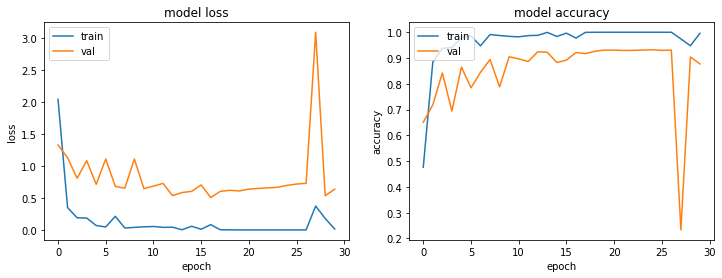

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

### 20 epochs, lr = 0.001


In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_15 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_16 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = 'Adam', batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 98s 370ms/step - loss: 3.3072 - categorical_accuracy: 0.2427 - val_loss: 1.2429 - val_categorical_accuracy: 0.6678
Epoch 2/20
265/265 [==============================] - 98s 369ms/step - loss: 0.3885 - categorical_accuracy: 0.8736 - val_loss: 0.7585 - val_categorical_accuracy: 0.8129
Epoch 3/20
265/265 [==============================] - 97s 368ms/step - loss: 0.1790 - categorical_accuracy: 0.9415 - val_loss: 0.6534 - val_categorical_accuracy: 0.8421
Epoch 4/20
265/265 [==============================] - 97s 368ms/step - loss: 0.0710 - categorical_accuracy: 0.9793 - val_loss: 0.6298 - val_categorical_accuracy: 0.8838
Epoch 5/20
265/265 [==============================] - 97s 367ms/step - loss: 0.1713 - categorical_accuracy: 0.9487 - val_loss: 0.5546 - val_categorical_accuracy: 0.8916
Epoch 6/20
265/265 [

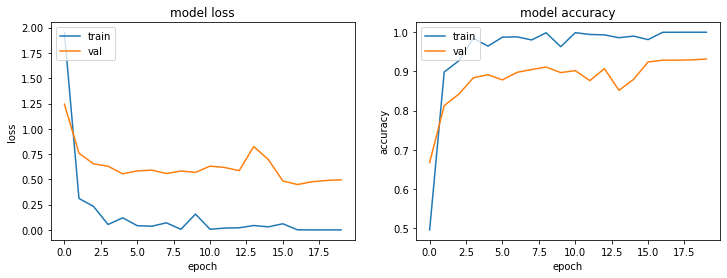

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

45/45 [==============================] - 14s 321ms/step - loss: 0.4959 - categorical_accuracy: 0.9316


0.9316480159759521

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 321ms/step - loss: 0.1822 - categorical_accuracy: 0.9745


0.974503755569458

### 20 epochs, lr = 0.0001

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_6 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_30 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_31 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.0001)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 102s 383ms/step - loss: 3.3552 - categorical_accuracy: 0.2814 - val_loss: 1.4865 - val_categorical_accuracy: 0.6216
Epoch 2/20
265/265 [==============================] - 100s 379ms/step - loss: 0.4582 - categorical_accuracy: 0.8923 - val_loss: 0.8853 - val_categorical_accuracy: 0.7631
Epoch 3/20
265/265 [==============================] - 101s 381ms/step - loss: 0.1793 - categorical_accuracy: 0.9630 - val_loss: 0.6699 - val_categorical_accuracy: 0.8191
Epoch 4/20
265/265 [==============================] - 101s 380ms/step - loss: 0.0868 - categorical_accuracy: 0.9845 - val_loss: 0.5518 - val_categorical_accuracy: 0.8596
Epoch 5/20
265/265 [==============================] - 100s 379ms/step - loss: 0.0515 - categorical_accuracy: 0.9923 - val_loss: 0.4986 - val_categorical_accuracy: 0.8792
Epoch 6/20
265/

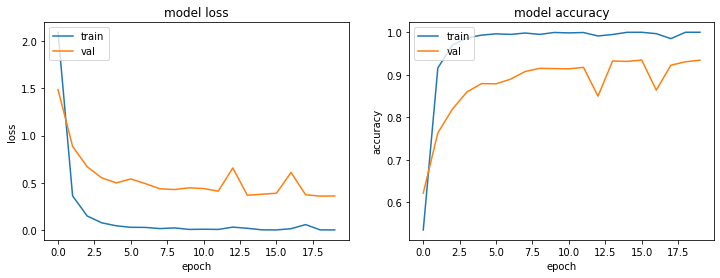

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
# Modello di prima ma abbassando il learning rate
# Modello nuovo con regolarizzazione per avvicinare il validation al train

### 20 epochs, lr = 0.00005

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 28, 28, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4818944   
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 110s 403ms/step - loss: 3.8433 - categorical_accuracy: 0.1988 - val_loss: 1.5353 - val_categorical_accuracy: 0.6476
Epoch 2/20
265/265 [==============================] - 105s 397ms/step - loss: 0.8490 - categorical_accuracy: 0.8205 - val_loss: 0.8897 - val_categorical_accuracy: 0.7860
Epoch 3/20
265/265 [==============================] - 105s 396ms/step - loss: 0.3669 - categorical_accuracy: 0.9242 - val_loss: 0.6334 - val_categorical_accuracy: 0.8396
Epoch 4/20
265/265 [==============================] - 104s 392ms/step - loss: 0.2048 - categorical_accuracy: 0.9621 - val_loss: 0.5100 - val_categorical_accuracy: 0.8614
Epoch 5/20
265/265 [==============================] - 120s 453ms/step - loss: 0.1220 - categorical_accuracy: 0.9814 - val_loss: 0.4584 - val_categorical_accuracy: 0.8795
Epoch 6/20
265/

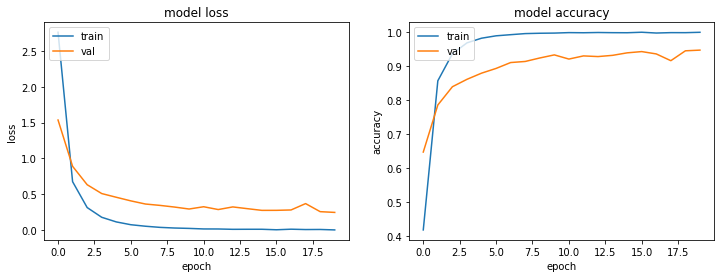

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 15s 328ms/step - loss: 0.2876 - categorical_accuracy: 0.9415


0.9415132403373718

## First model with regularization: dropout

### Error mode: dropout without last layer

#### Dropout 0.2

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.2

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4818944   
_________________________________________________________________
activation_5 (Activation)    (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 101s 381ms/step - loss: 4.4037 - categorical_accuracy: 0.0707 - val_loss: 2.0877 - val_categorical_accuracy: 0.5332
Epoch 2/20
265/265 [==============================] - 99s 374ms/step - loss: 1.8521 - categorical_accuracy: 0.4919 - val_loss: 1.0823 - val_categorical_accuracy: 0.7347
Epoch 3/20
265/265 [==============================] - 99s 374ms/step - loss: 0.9374 - categorical_accuracy: 0.7270 - val_loss: 0.7620 - val_categorical_accuracy: 0.7921
Epoch 4/20
265/265 [==============================] - 99s 372ms/step - loss: 0.5870 - categorical_accuracy: 0.8285 - val_loss: 0.5841 - val_categorical_accuracy: 0.8444
Epoch 5/20
265/265 [==============================] - 99s 373ms/step - loss: 0.3966 - categorical_accuracy: 0.8835 - val_loss: 0.4713 - val_categorical_accuracy: 0.8719
Epoch 6/20
265/265 

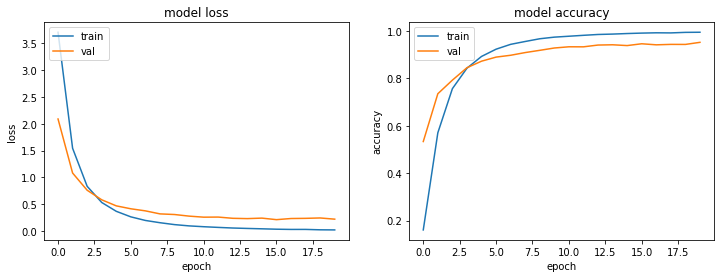

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 312ms/step - loss: 0.2548 - categorical_accuracy: 0.9479


0.9479432702064514

#### Dropout 0.3

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.3

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_15 (Activation)   (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_16 (Activation)   (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 99s 370ms/step - loss: 4.6148 - categorical_accuracy: 0.0408 - val_loss: 2.7054 - val_categorical_accuracy: 0.3573
Epoch 2/20
265/265 [==============================] - 98s 369ms/step - loss: 2.5094 - categorical_accuracy: 0.3285 - val_loss: 1.3538 - val_categorical_accuracy: 0.6740
Epoch 3/20
265/265 [==============================] - 98s 369ms/step - loss: 1.3687 - categorical_accuracy: 0.6037 - val_loss: 0.9294 - val_categorical_accuracy: 0.7633
Epoch 4/20
265/265 [==============================] - 97s 368ms/step - loss: 0.8841 - categorical_accuracy: 0.7337 - val_loss: 0.7090 - val_categorical_accuracy: 0.8146
Epoch 5/20
265/265 [==============================] - 97s 368ms/step - loss: 0.6273 - categorical_accuracy: 0.8095 - val_loss: 0.5999 - val_categorical_accuracy: 0.8402
Epoch 6/20
265/265 [

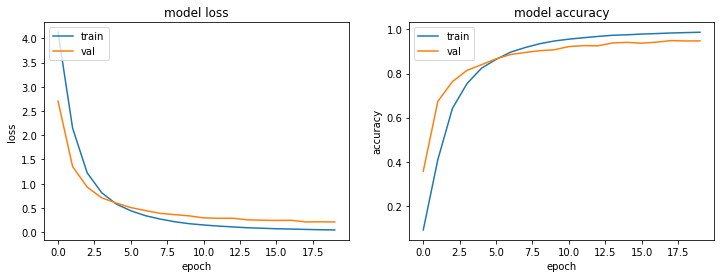

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 309ms/step - loss: 0.2401 - categorical_accuracy: 0.9434


0.9433630108833313

#### Dropout 0.4

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.4

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_10 (Activation)   (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_11 (Activation)   (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 98s 368ms/step - loss: 4.7803 - categorical_accuracy: 0.0229 - val_loss: 3.4872 - val_categorical_accuracy: 0.1690
Epoch 2/20
265/265 [==============================] - 98s 370ms/step - loss: 3.2889 - categorical_accuracy: 0.1779 - val_loss: 1.9160 - val_categorical_accuracy: 0.5603
Epoch 3/20
265/265 [==============================] - 98s 369ms/step - loss: 2.0401 - categorical_accuracy: 0.4207 - val_loss: 1.2541 - val_categorical_accuracy: 0.7093
Epoch 4/20
265/265 [==============================] - 98s 370ms/step - loss: 1.3692 - categorical_accuracy: 0.5930 - val_loss: 0.9389 - val_categorical_accuracy: 0.7708
Epoch 5/20
265/265 [==============================] - 98s 369ms/step - loss: 1.0020 - categorical_accuracy: 0.6934 - val_loss: 0.7677 - val_categorical_accuracy: 0.7962
Epoch 6/20
265/265 [

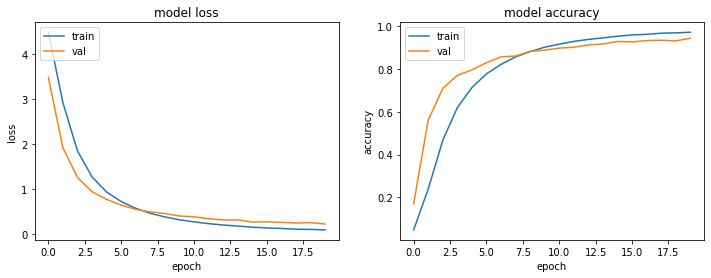

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 307ms/step - loss: 0.2483 - categorical_accuracy: 0.9404


0.9403681755065918

#### Dropout 0.5

##### 20 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.5

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_20 (Activation)   (None, 2048)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_21 (Activation)   (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 97s 365ms/step - loss: 4.8936 - categorical_accuracy: 0.0137 - val_loss: 4.2564 - val_categorical_accuracy: 0.0573
Epoch 2/20
265/265 [==============================] - 97s 366ms/step - loss: 4.0785 - categorical_accuracy: 0.0719 - val_loss: 2.7935 - val_categorical_accuracy: 0.3087
Epoch 3/20
265/265 [==============================] - 97s 365ms/step - loss: 2.9223 - categorical_accuracy: 0.2163 - val_loss: 1.8862 - val_categorical_accuracy: 0.5425
Epoch 4/20
265/265 [==============================] - 97s 365ms/step - loss: 2.1350 - categorical_accuracy: 0.3759 - val_loss: 1.3758 - val_categorical_accuracy: 0.6760
Epoch 5/20
265/265 [==============================] - 97s 365ms/step - loss: 1.6199 - categorical_accuracy: 0.5123 - val_loss: 1.0759 - val_categorical_accuracy: 0.7360
Epoch 6/20
265/265 [

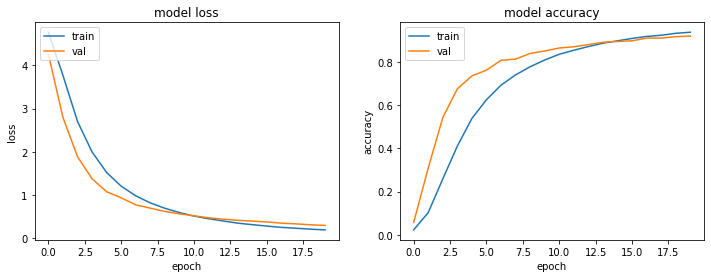

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 321ms/step - loss: 0.3367 - categorical_accuracy: 0.9119


0.9119175672531128

##### 25 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.5

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 28, 28, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4818944   
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 25
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/25
265/265 [==============================] - 115s 427ms/step - loss: 4.8951 - categorical_accuracy: 0.0136 - val_loss: 4.2570 - val_categorical_accuracy: 0.0687
Epoch 2/25
265/265 [==============================] - 112s 422ms/step - loss: 4.0739 - categorical_accuracy: 0.0722 - val_loss: 2.8369 - val_categorical_accuracy: 0.2860
Epoch 3/25
265/265 [==============================] - 110s 417ms/step - loss: 2.9284 - categorical_accuracy: 0.2169 - val_loss: 1.8961 - val_categorical_accuracy: 0.5438
Epoch 4/25
265/265 [==============================] - 109s 412ms/step - loss: 2.1286 - categorical_accuracy: 0.3820 - val_loss: 1.3733 - val_categorical_accuracy: 0.6643
Epoch 5/25
265/265 [==============================] - 109s 413ms/step - loss: 1.5942 - categorical_accuracy: 0.5179 - val_loss: 1.0741 - val_categorical_accuracy: 0.7380
Epoch 6/25
265/

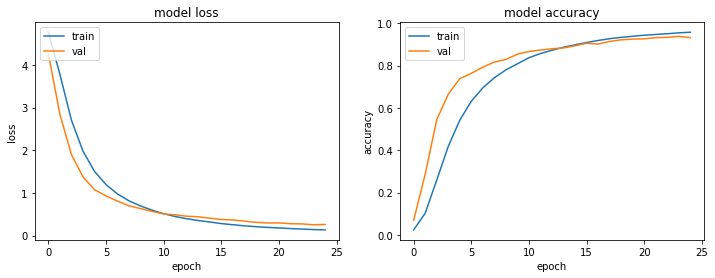

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 16s 346ms/step - loss: 0.2897 - categorical_accuracy: 0.9258


0.925834596157074

##### 30 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.5

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4818944   
_________________________________________________________________
activation_5 (Activation)    (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 30
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/30
265/265 [==============================] - 108s 404ms/step - loss: 4.8943 - categorical_accuracy: 0.0138 - val_loss: 4.2488 - val_categorical_accuracy: 0.0619
Epoch 2/30
265/265 [==============================] - 108s 407ms/step - loss: 4.0748 - categorical_accuracy: 0.0729 - val_loss: 2.7914 - val_categorical_accuracy: 0.2909
Epoch 3/30
265/265 [==============================] - 107s 405ms/step - loss: 2.9174 - categorical_accuracy: 0.2133 - val_loss: 1.9025 - val_categorical_accuracy: 0.5369
Epoch 4/30
265/265 [==============================] - 106s 402ms/step - loss: 2.1352 - categorical_accuracy: 0.3795 - val_loss: 1.3661 - val_categorical_accuracy: 0.6758
Epoch 5/30
265/265 [==============================] - 105s 396ms/step - loss: 1.6090 - categorical_accuracy: 0.5142 - val_loss: 1.0969 - val_categorical_accuracy: 0.7238
Epoch 6/30
265/

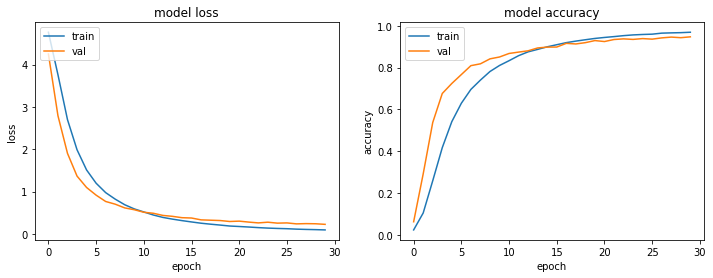

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

45/45 [==============================] - 15s 340ms/step - loss: 0.2263 - categorical_accuracy: 0.9469


0.9468901753425598

### Right mode: dropout with last layer

#### Dropout 0.05


##### 20 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.05

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4818944   
_________________________________________________________________
activation_5 (Activation)    (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 105s 396ms/step - loss: 4.0479 - categorical_accuracy: 0.1355 - val_loss: 1.5872 - val_categorical_accuracy: 0.6440
Epoch 2/20
265/265 [==============================] - 105s 395ms/step - loss: 1.3074 - categorical_accuracy: 0.6485 - val_loss: 0.8776 - val_categorical_accuracy: 0.7836
Epoch 3/20
265/265 [==============================] - 105s 395ms/step - loss: 0.6459 - categorical_accuracy: 0.8171 - val_loss: 0.6242 - val_categorical_accuracy: 0.8378
Epoch 4/20
265/265 [==============================] - 104s 392ms/step - loss: 0.3946 - categorical_accuracy: 0.8896 - val_loss: 0.4744 - val_categorical_accuracy: 0.8710
Epoch 5/20
265/265 [==============================] - 104s 393ms/step - loss: 0.2547 - categorical_accuracy: 0.9319 - val_loss: 0.3745 - val_categorical_accuracy: 0.9004
Epoch 6/20
265/

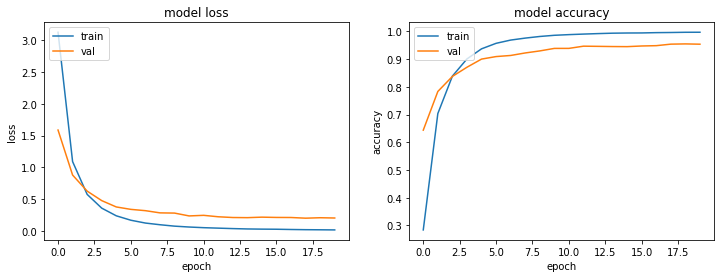

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 17s 383ms/step - loss: 0.2309 - categorical_accuracy: 0.9506


0.9505857229232788

##### 30 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.05

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_10 (Activation)   (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_11 (Activation)   (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 30
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/30
265/265 [==============================] - 121s 453ms/step - loss: 4.0559 - categorical_accuracy: 0.1323 - val_loss: 1.6499 - val_categorical_accuracy: 0.6420
Epoch 2/30
265/265 [==============================] - 119s 451ms/step - loss: 1.3244 - categorical_accuracy: 0.6425 - val_loss: 0.8909 - val_categorical_accuracy: 0.7786
Epoch 3/30
265/265 [==============================] - 119s 449ms/step - loss: 0.6498 - categorical_accuracy: 0.8182 - val_loss: 0.6114 - val_categorical_accuracy: 0.8381
Epoch 4/30
265/265 [==============================] - 119s 449ms/step - loss: 0.3836 - categorical_accuracy: 0.8934 - val_loss: 0.4775 - val_categorical_accuracy: 0.8722
Epoch 5/30
265/265 [==============================] - 119s 450ms/step - loss: 0.2584 - categorical_accuracy: 0.9289 - val_loss: 0.3997 - val_categorical_accuracy: 0.8956
Epoch 6/30
265/

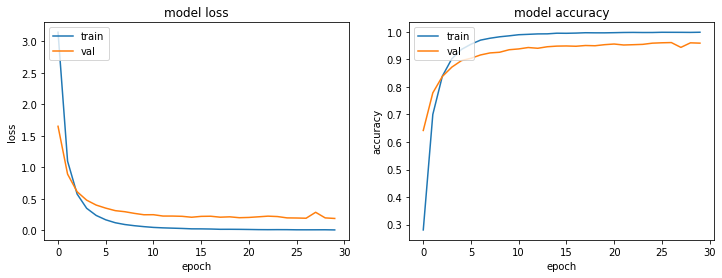

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 15s 324ms/step - loss: 0.2119 - categorical_accuracy: 0.9572


0.9571919441223145

##### 40 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.05

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_15 (Activation)   (None, 2048)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_16 (Activation)   (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 40
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/40
265/265 [==============================] - 103s 387ms/step - loss: 4.0506 - categorical_accuracy: 0.1313 - val_loss: 1.5850 - val_categorical_accuracy: 0.6453
Epoch 2/40
265/265 [==============================] - 102s 385ms/step - loss: 1.2822 - categorical_accuracy: 0.6563 - val_loss: 0.8552 - val_categorical_accuracy: 0.7831
Epoch 3/40
265/265 [==============================] - 102s 386ms/step - loss: 0.6317 - categorical_accuracy: 0.8238 - val_loss: 0.6440 - val_categorical_accuracy: 0.8375
Epoch 4/40
265/265 [==============================] - 102s 385ms/step - loss: 0.3797 - categorical_accuracy: 0.8936 - val_loss: 0.4780 - val_categorical_accuracy: 0.8723
Epoch 5/40
265/265 [==============================] - 102s 386ms/step - loss: 0.2501 - categorical_accuracy: 0.9324 - val_loss: 0.4140 - val_categorical_accuracy: 0.8890
Epoch 6/40
265/

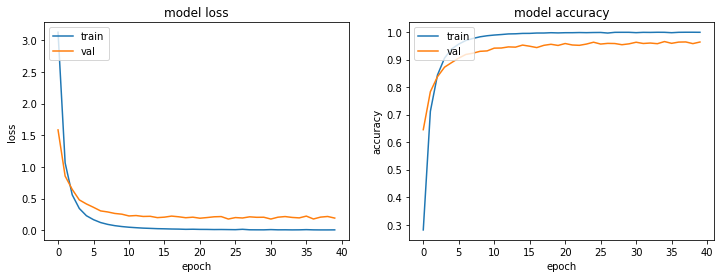

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 15s 334ms/step - loss: 0.2257 - categorical_accuracy: 0.9594


0.9593939781188965

In [ ]:
MyModel.save('drive/MyDrive/AML-Project/FNN_models/model_dropout40')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/FNN_models/model_dropout40/assets


#### Dropout 0.1

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.1

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 28, 28, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4818944   
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 115s 425ms/step - loss: 4.2471 - categorical_accuracy: 0.0938 - val_loss: 1.8938 - val_categorical_accuracy: 0.5977
Epoch 2/20
265/265 [==============================] - 112s 421ms/step - loss: 1.6992 - categorical_accuracy: 0.5366 - val_loss: 1.0069 - val_categorical_accuracy: 0.7605
Epoch 3/20
265/265 [==============================] - 111s 420ms/step - loss: 0.8725 - categorical_accuracy: 0.7485 - val_loss: 0.7047 - val_categorical_accuracy: 0.8195
Epoch 4/20
265/265 [==============================] - 126s 475ms/step - loss: 0.5432 - categorical_accuracy: 0.8435 - val_loss: 0.5292 - val_categorical_accuracy: 0.8605
Epoch 5/20
265/265 [==============================] - 125s 470ms/step - loss: 0.3622 - categorical_accuracy: 0.8956 - val_loss: 0.4424 - val_categorical_accuracy: 0.8886
Epoch 6/20
265/

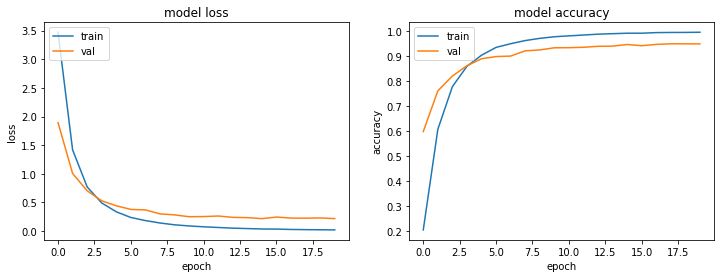

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 15s 337ms/step - loss: 0.2452 - categorical_accuracy: 0.9474


0.947414755821228

#### Dropout 0.2

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.2

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_10 (Activation)   (None, 2048)              0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_11 (Activation)   (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 119s 440ms/step - loss: 4.5300 - categorical_accuracy: 0.0488 - val_loss: 2.4801 - val_categorical_accuracy: 0.4490
Epoch 2/20
265/265 [==============================] - 116s 437ms/step - loss: 2.4653 - categorical_accuracy: 0.3472 - val_loss: 1.2604 - val_categorical_accuracy: 0.7004
Epoch 3/20
265/265 [==============================] - 114s 432ms/step - loss: 1.4116 - categorical_accuracy: 0.5930 - val_loss: 0.8768 - val_categorical_accuracy: 0.7803
Epoch 4/20
265/265 [==============================] - 113s 426ms/step - loss: 0.9351 - categorical_accuracy: 0.7258 - val_loss: 0.6471 - val_categorical_accuracy: 0.8311
Epoch 5/20
265/265 [==============================] - 112s 421ms/step - loss: 0.6462 - categorical_accuracy: 0.8079 - val_loss: 0.5444 - val_categorical_accuracy: 0.8578
Epoch 6/20
265/

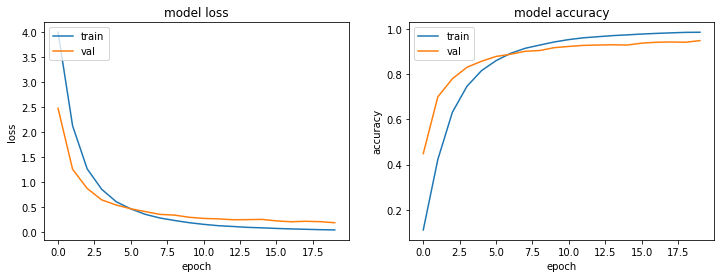

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 16s 353ms/step - loss: 0.2204 - categorical_accuracy: 0.9436


0.9436272382736206

In [ ]:
MyModel.save('drive/MyDrive/AML-Project/FNN_models/model_dropout')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/FNN_models/model_dropout/assets


#### Dropout 0.3

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.3

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_15 (Activation)   (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_16 (Activation)   (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 109s 409ms/step - loss: 4.7560 - categorical_accuracy: 0.0261 - val_loss: 3.4681 - val_categorical_accuracy: 0.2301
Epoch 2/20
265/265 [==============================] - 108s 408ms/step - loss: 3.4065 - categorical_accuracy: 0.1703 - val_loss: 1.9002 - val_categorical_accuracy: 0.5793
Epoch 3/20
265/265 [==============================] - 108s 406ms/step - loss: 2.2191 - categorical_accuracy: 0.3904 - val_loss: 1.2314 - val_categorical_accuracy: 0.7170
Epoch 4/20
265/265 [==============================] - 108s 406ms/step - loss: 1.5784 - categorical_accuracy: 0.5425 - val_loss: 0.9411 - val_categorical_accuracy: 0.7711
Epoch 5/20
265/265 [==============================] - 107s 403ms/step - loss: 1.1760 - categorical_accuracy: 0.6515 - val_loss: 0.7569 - val_categorical_accuracy: 0.8103
Epoch 6/20
265/

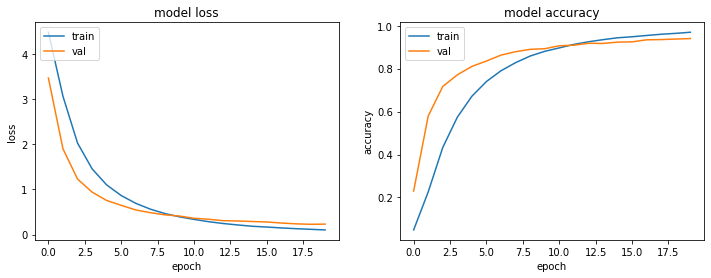

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 16s 343ms/step - loss: 0.2615 - categorical_accuracy: 0.9373


0.937285304069519

## First model with regularization: L2

### 0.01

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
regul = regularizers.l2(0.01)
activ = 'relu'
p_dropout = 0.2

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 28, 28, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4818944   
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 115s 422ms/step - loss: 42.9687 - categorical_accuracy: 0.1218 - val_loss: 25.8933 - val_categorical_accuracy: 0.5067
Epoch 2/20
265/265 [==============================] - 127s 479ms/step - loss: 22.3750 - categorical_accuracy: 0.6587 - val_loss: 15.5165 - val_categorical_accuracy: 0.6798
Epoch 3/20
265/265 [==============================] - 118s 444ms/step - loss: 13.6687 - categorical_accuracy: 0.8069 - val_loss: 10.5216 - val_categorical_accuracy: 0.7344
Epoch 4/20
265/265 [==============================] - 104s 391ms/step - loss: 9.4136 - categorical_accuracy: 0.8549 - val_loss: 7.9335 - val_categorical_accuracy: 0.7543
Epoch 5/20
265/265 [==============================] - 103s 387ms/step - loss: 7.1547 - categorical_accuracy: 0.8799 - val_loss: 6.4199 - val_categorical_accuracy: 0.7824
Epoch 6/2

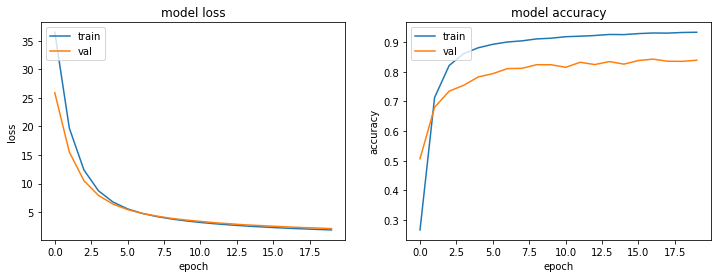

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 318ms/step - loss: 2.1794 - categorical_accuracy: 0.8243


0.8242754936218262

### 0.001

#### 20 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
regul = regularizers.l2(0.001)
activ = 'relu'
p_dropout = 0.2

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 2048)              4818944   
_________________________________________________________________
activation_5 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 99s 372ms/step - loss: 8.1110 - categorical_accuracy: 0.1922 - val_loss: 5.1090 - val_categorical_accuracy: 0.6452
Epoch 2/20
265/265 [==============================] - 98s 370ms/step - loss: 4.2992 - categorical_accuracy: 0.8092 - val_loss: 3.9981 - val_categorical_accuracy: 0.7665
Epoch 3/20
265/265 [==============================] - 107s 405ms/step - loss: 3.3893 - categorical_accuracy: 0.9152 - val_loss: 3.4657 - val_categorical_accuracy: 0.8178
Epoch 4/20
265/265 [==============================] - 114s 431ms/step - loss: 2.9710 - categorical_accuracy: 0.9549 - val_loss: 3.1110 - val_categorical_accuracy: 0.8578
Epoch 5/20
265/265 [==============================] - 115s 433ms/step - loss: 2.6949 - categorical_accuracy: 0.9731 - val_loss: 2.8555 - val_categorical_accuracy: 0.8850
Epoch 6/20
265/26

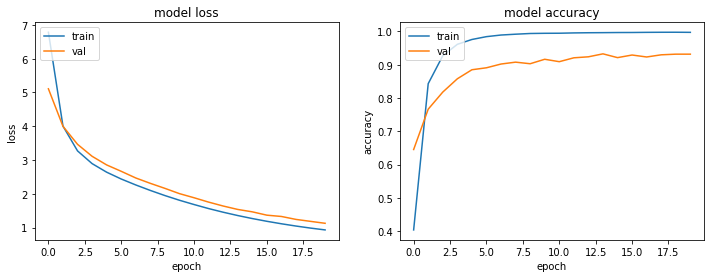

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 317ms/step - loss: 1.1606 - categorical_accuracy: 0.9287


0.9286532402038574

#### 25 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
regul = regularizers.l2(0.001)
activ = 'relu'
p_dropout = 0.2

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_10 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_11 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 25
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/25
265/265 [==============================] - 100s 374ms/step - loss: 8.1115 - categorical_accuracy: 0.1887 - val_loss: 5.1158 - val_categorical_accuracy: 0.6412
Epoch 2/25
265/265 [==============================] - 99s 373ms/step - loss: 4.3017 - categorical_accuracy: 0.8040 - val_loss: 3.9631 - val_categorical_accuracy: 0.7590
Epoch 3/25
265/265 [==============================] - 99s 373ms/step - loss: 3.3791 - categorical_accuracy: 0.9147 - val_loss: 3.4441 - val_categorical_accuracy: 0.8151
Epoch 4/25
265/265 [==============================] - 99s 372ms/step - loss: 2.9533 - categorical_accuracy: 0.9557 - val_loss: 3.0984 - val_categorical_accuracy: 0.8576
Epoch 5/25
265/265 [==============================] - 98s 371ms/step - loss: 2.6825 - categorical_accuracy: 0.9724 - val_loss: 2.8651 - val_categorical_accuracy: 0.8705
Epoch 6/25
265/265 

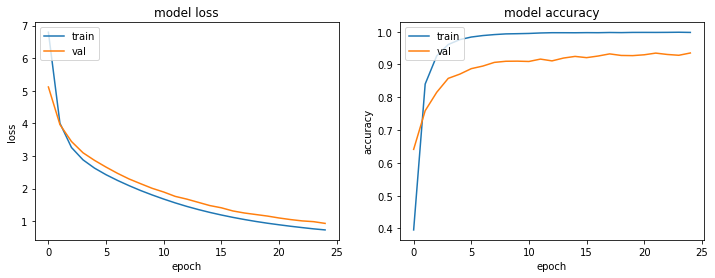

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 317ms/step - loss: 1.1606 - categorical_accuracy: 0.9287


0.9286532402038574

#### 30 epochs

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
regul = regularizers.l2(0.001)
activ = 'relu'
p_dropout = 0.2

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(1024, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    #Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights, kernel_regularizer=regul),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_15 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_16 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 30
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/30
265/265 [==============================] - 99s 372ms/step - loss: 8.0845 - categorical_accuracy: 0.2014 - val_loss: 5.1279 - val_categorical_accuracy: 0.6376
Epoch 2/30
265/265 [==============================] - 98s 371ms/step - loss: 4.3042 - categorical_accuracy: 0.8105 - val_loss: 4.0121 - val_categorical_accuracy: 0.7665
Epoch 3/30
265/265 [==============================] - 98s 369ms/step - loss: 3.4254 - categorical_accuracy: 0.9131 - val_loss: 3.5066 - val_categorical_accuracy: 0.8128
Epoch 4/30
265/265 [==============================] - 98s 369ms/step - loss: 3.0036 - categorical_accuracy: 0.9552 - val_loss: 3.1775 - val_categorical_accuracy: 0.8469
Epoch 5/30
265/265 [==============================] - 98s 370ms/step - loss: 2.7299 - categorical_accuracy: 0.9737 - val_loss: 2.9148 - val_categorical_accuracy: 0.8672
Epoch 6/30
265/265 [

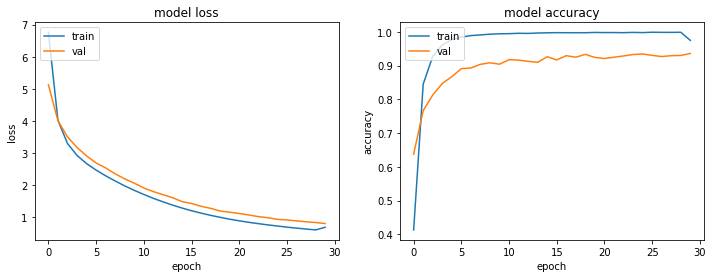

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 309ms/step - loss: 0.8407 - categorical_accuracy: 0.9277


0.9276843070983887

## First model with data augmentation

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    #Dropout(0.4),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 28, 28, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4818944   
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               5

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = True
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

# AUGMENTATION OPTIONS -----------------------

rot_range = 45
width_shift = 0.15
height_shift = 0.15
zoom_range = [0.9, 1.5] #zoom < 1 è zoom in, zoom > 1 è zoom out.
horflip = True
verflip = True

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = rot_range, aug_width = width_shift, aug_height = height_shift, aug_zoom = zoom_range, 
              aug_horflip = horflip, aug_verflip = verflip,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 725s 3s/step - loss: 4.3396 - categorical_accuracy: 0.0647 - val_loss: 2.9961 - val_categorical_accuracy: 0.2184
Epoch 2/20
265/265 [==============================] - 721s 3s/step - loss: 2.3941 - categorical_accuracy: 0.3466 - val_loss: 2.0704 - val_categorical_accuracy: 0.4390
Epoch 3/20
265/265 [==============================] - 721s 3s/step - loss: 1.6173 - categorical_accuracy: 0.5340 - val_loss: 1.7052 - val_categorical_accuracy: 0.5339
Epoch 4/20
265/265 [==============================] - 721s 3s/step - loss: 1.2698 - categorical_accuracy: 0.6251 - val_loss: 1.5284 - val_categorical_accuracy: 0.5597
Epoch 5/20
265/265 [==============================] - 715s 3s/step - loss: 1.0843 - categorical_accuracy: 0.6671 - val_loss: 1.4037 - val_categorical_accuracy: 0.6069
Epoch 6/20
265/265 [==========

In [ ]:
MyModel.save('drive/MyDrive/AML-Project/FNN_models/aug_model')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/FNN_models/aug_model/assets


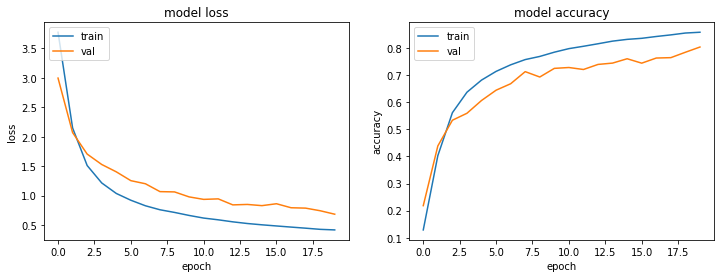

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
MyModel = keras.models.load_model('drive/MyDrive/AML-Project/FNN_models/aug_model')

In [ ]:
results_test = MyModel.evaluate(outputs[2])
results_test[1]

NameError: ignored

## Variations of the first model: removing or adding layers

### Only output layer (131)



In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_17 (Dense)             (None, 131)               308243    
_________________________________________________________________
activation_17 (Activation)   (None, 131)               0         
Total params: 308,243
Trainable params: 308,243
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 109s 411ms/step - loss: 4.6581 - categorical_accuracy: 0.0689 - val_loss: 3.7198 - val_categorical_accuracy: 0.3099
Epoch 2/20
265/265 [==============================] - 110s 416ms/step - loss: 3.4243 - categorical_accuracy: 0.4220 - val_loss: 3.0453 - val_categorical_accuracy: 0.4786
Epoch 3/20
265/265 [==============================] - 110s 417ms/step - loss: 2.7474 - categorical_accuracy: 0.5984 - val_loss: 2.6125 - val_categorical_accuracy: 0.5643
Epoch 4/20
265/265 [==============================] - 110s 417ms/step - loss: 2.2903 - categorical_accuracy: 0.6916 - val_loss: 2.3090 - val_categorical_accuracy: 0.6153
Epoch 5/20
265/265 [==============================] - 111s 418ms/step - loss: 1.9728 - categorical_accuracy: 0.7407 - val_loss: 2.0858 - val_categorical_accuracy: 0.6337
Epoch 6/20
265/

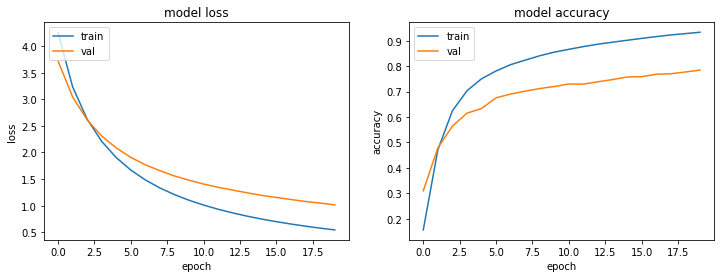

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 15s 339ms/step - loss: 1.0721 - categorical_accuracy: 0.7721


0.7721307277679443

### 1 hidden layer (256)

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               602368    
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 131)               33667     
_________________________________________________________________
activation_16 (Activation)   (None, 131)               0         
Total params: 636,035
Trainable params: 636,035
Non-trainable params: 0
________________________________________________

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 110s 415ms/step - loss: 4.5809 - categorical_accuracy: 0.0717 - val_loss: 3.5799 - val_categorical_accuracy: 0.2824
Epoch 2/20
265/265 [==============================] - 109s 410ms/step - loss: 3.1279 - categorical_accuracy: 0.4105 - val_loss: 2.5863 - val_categorical_accuracy: 0.5140
Epoch 3/20
265/265 [==============================] - 109s 411ms/step - loss: 2.1429 - categorical_accuracy: 0.6570 - val_loss: 2.0218 - val_categorical_accuracy: 0.6233
Epoch 4/20
265/265 [==============================] - 109s 411ms/step - loss: 1.5819 - categorical_accuracy: 0.7642 - val_loss: 1.6867 - val_categorical_accuracy: 0.6692
Epoch 5/20
265/265 [==============================] - 109s 410ms/step - loss: 1.2236 - categorical_accuracy: 0.8145 - val_loss: 1.4569 - val_categorical_accuracy: 0.7000
Epoch 6/20
265/

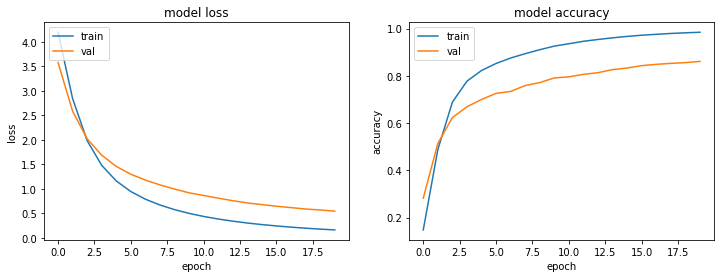

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 16s 352ms/step - loss: 0.5872 - categorical_accuracy: 0.8503


0.8502598404884338

### 2 hidden layers (512 + 256)

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_5 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               1204736   
_________________________________________________________________
activation_18 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 131)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 109s 411ms/step - loss: 4.3631 - categorical_accuracy: 0.1011 - val_loss: 2.8252 - val_categorical_accuracy: 0.4221
Epoch 2/20
265/265 [==============================] - 108s 409ms/step - loss: 2.1941 - categorical_accuracy: 0.6039 - val_loss: 1.7487 - val_categorical_accuracy: 0.6415
Epoch 3/20
265/265 [==============================] - 108s 409ms/step - loss: 1.2165 - categorical_accuracy: 0.7919 - val_loss: 1.3165 - val_categorical_accuracy: 0.7126
Epoch 4/20
265/265 [==============================] - 108s 408ms/step - loss: 0.7936 - categorical_accuracy: 0.8546 - val_loss: 1.0734 - val_categorical_accuracy: 0.7449
Epoch 5/20
265/265 [==============================] - 108s 409ms/step - loss: 0.5698 - categorical_accuracy: 0.8983 - val_loss: 0.9112 - val_categorical_accuracy: 0.7819
Epoch 6/20
265/

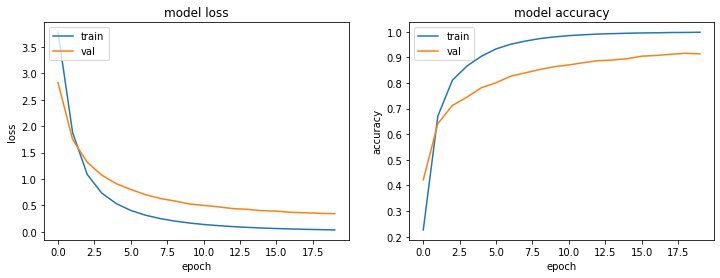

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 16s 347ms/step - loss: 0.3798 - categorical_accuracy: 0.9100


0.9099797606468201

### 3 hidden layers (1024 + 512 + 256)

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2409472   
_________________________________________________________________
activation_6 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 97s 364ms/step - loss: 4.1494 - categorical_accuracy: 0.1436 - val_loss: 2.1563 - val_categorical_accuracy: 0.5137
Epoch 2/20
265/265 [==============================] - 97s 368ms/step - loss: 1.4339 - categorical_accuracy: 0.7239 - val_loss: 1.2100 - val_categorical_accuracy: 0.7167
Epoch 3/20
265/265 [==============================] - 97s 365ms/step - loss: 0.6605 - categorical_accuracy: 0.8681 - val_loss: 0.8814 - val_categorical_accuracy: 0.7817
Epoch 4/20
265/265 [==============================] - 97s 367ms/step - loss: 0.3960 - categorical_accuracy: 0.9272 - val_loss: 0.6892 - val_categorical_accuracy: 0.8303
Epoch 5/20
265/265 [==============================] - 98s 369ms/step - loss: 0.2562 - categorical_accuracy: 0.9576 - val_loss: 0.5742 - val_categorical_accuracy: 0.8521
Epoch 6/20
265/265 [

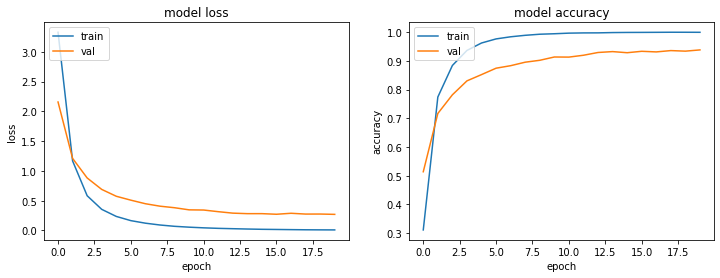

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 305ms/step - loss: 0.3076 - categorical_accuracy: 0.9345


0.9344666600227356

In [ ]:
MyModel.save('drive/MyDrive/AML-Project/FNN_models/model_3layers')

INFO:tensorflow:Assets written to: drive/MyDrive/AML-Project/FNN_models/model_3layers/assets


### 5 hidden layers (2048 + 2048 + 1024 + 512 + 256)

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_6 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_21 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
activation_22 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 114s 426ms/step - loss: 3.5975 - categorical_accuracy: 0.2373 - val_loss: 1.2386 - val_categorical_accuracy: 0.7017
Epoch 2/20
265/265 [==============================] - 115s 434ms/step - loss: 0.6050 - categorical_accuracy: 0.8585 - val_loss: 0.7507 - val_categorical_accuracy: 0.8087
Epoch 3/20
265/265 [==============================] - 115s 434ms/step - loss: 0.2476 - categorical_accuracy: 0.9441 - val_loss: 0.5403 - val_categorical_accuracy: 0.8528
Epoch 4/20
265/265 [==============================] - 113s 428ms/step - loss: 0.1276 - categorical_accuracy: 0.9750 - val_loss: 0.4402 - val_categorical_accuracy: 0.8814
Epoch 5/20
265/265 [==============================] - 113s 425ms/step - loss: 0.0741 - categorical_accuracy: 0.9866 - val_loss: 0.3881 - val_categorical_accuracy: 0.8947
Epoch 6/20
265/

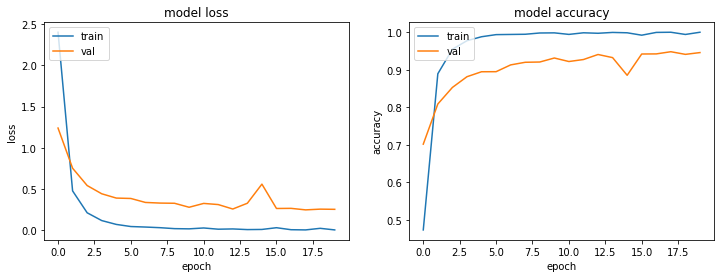

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 16s 360ms/step - loss: 0.2969 - categorical_accuracy: 0.9417


0.9416894316673279

### 5 hidden layers (2048 + 1024 + 1024 + 512 + 256)

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 28, 28, 3)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4818944   
_________________________________________________________________
activation (Activation)      (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 112s 414ms/step - loss: 3.7203 - categorical_accuracy: 0.2102 - val_loss: 1.3320 - val_categorical_accuracy: 0.6575
Epoch 2/20
265/265 [==============================] - 102s 386ms/step - loss: 0.6917 - categorical_accuracy: 0.8317 - val_loss: 0.7885 - val_categorical_accuracy: 0.7880
Epoch 3/20
265/265 [==============================] - 102s 383ms/step - loss: 0.2960 - categorical_accuracy: 0.9302 - val_loss: 0.5705 - val_categorical_accuracy: 0.8435
Epoch 4/20
265/265 [==============================] - 100s 377ms/step - loss: 0.1594 - categorical_accuracy: 0.9655 - val_loss: 0.4414 - val_categorical_accuracy: 0.8853
Epoch 5/20
265/265 [==============================] - 98s 370ms/step - loss: 0.0886 - categorical_accuracy: 0.9838 - val_loss: 0.3865 - val_categorical_accuracy: 0.8972
Epoch 6/20
265/2

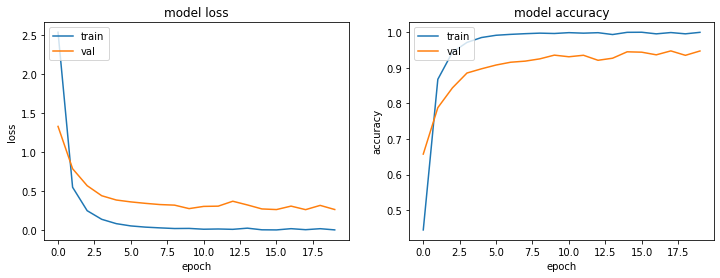

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 308ms/step - loss: 0.3040 - categorical_accuracy: 0.9432


0.9431868195533752

### 5 hidden layers (2048 + 1024 + 512 + 256 + 128)

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(128, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              4818944   
_________________________________________________________________
activation_14 (Activation)   (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
activation_15 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 107s 401ms/step - loss: 4.1494 - categorical_accuracy: 0.1292 - val_loss: 2.0112 - val_categorical_accuracy: 0.5406
Epoch 2/20
265/265 [==============================] - 106s 399ms/step - loss: 1.2208 - categorical_accuracy: 0.7294 - val_loss: 1.0366 - val_categorical_accuracy: 0.7473
Epoch 3/20
265/265 [==============================] - 106s 399ms/step - loss: 0.4566 - categorical_accuracy: 0.8961 - val_loss: 0.7161 - val_categorical_accuracy: 0.8164
Epoch 4/20
265/265 [==============================] - 106s 400ms/step - loss: 0.2462 - categorical_accuracy: 0.9502 - val_loss: 0.5750 - val_categorical_accuracy: 0.8475
Epoch 5/20
265/265 [==============================] - 106s 399ms/step - loss: 0.1562 - categorical_accuracy: 0.9707 - val_loss: 0.5002 - val_categorical_accuracy: 0.8734
Epoch 6/20
265/

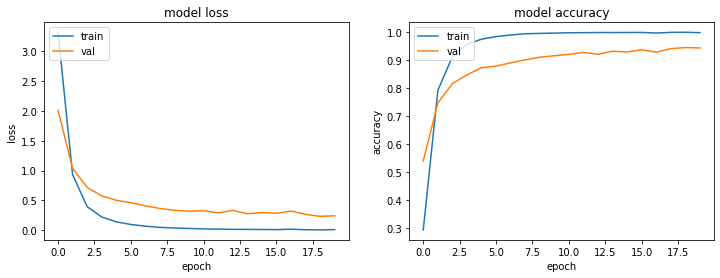

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 15s 338ms/step - loss: 0.2797 - categorical_accuracy: 0.9389


0.9388707876205444

### 6 hidden layers (2048 + 2048 + 1024 + 1024 + 512 + 256)

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dense(2048, kernel_initializer = init_weights),
    Activation(activ),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4818944   
_________________________________________________________________
activation_7 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
activation_8 (Activation)    (None, 2048)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)             

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 103s 386ms/step - loss: 3.5893 - categorical_accuracy: 0.2275 - val_loss: 1.2243 - val_categorical_accuracy: 0.6983
Epoch 2/20
265/265 [==============================] - 102s 384ms/step - loss: 0.5897 - categorical_accuracy: 0.8491 - val_loss: 0.7543 - val_categorical_accuracy: 0.7768
Epoch 3/20
265/265 [==============================] - 101s 382ms/step - loss: 0.2294 - categorical_accuracy: 0.9435 - val_loss: 0.5247 - val_categorical_accuracy: 0.8596
Epoch 4/20
265/265 [==============================] - 101s 381ms/step - loss: 0.1222 - categorical_accuracy: 0.9714 - val_loss: 0.4607 - val_categorical_accuracy: 0.8702
Epoch 5/20
265/265 [==============================] - 102s 383ms/step - loss: 0.0732 - categorical_accuracy: 0.9836 - val_loss: 0.3540 - val_categorical_accuracy: 0.9080
Epoch 6/20
265/

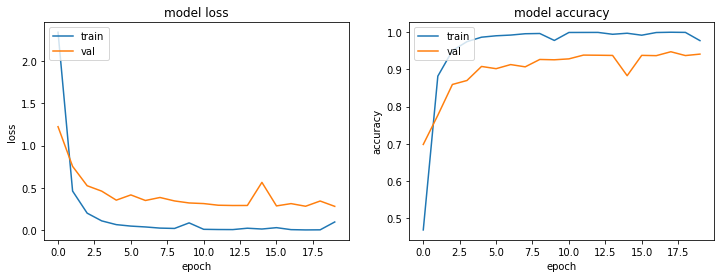

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 15s 339ms/step - loss: 0.3221 - categorical_accuracy: 0.9363


0.9363163709640503

## Regularizing 3-layer variation

### Dropout 0.2

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.2

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              2409472   
_________________________________________________________________
activation_10 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_11 (Activation)   (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 98s 367ms/step - loss: 4.5655 - categorical_accuracy: 0.0499 - val_loss: 2.9013 - val_categorical_accuracy: 0.3620
Epoch 2/20
265/265 [==============================] - 97s 365ms/step - loss: 2.7592 - categorical_accuracy: 0.2997 - val_loss: 1.6032 - val_categorical_accuracy: 0.6664
Epoch 3/20
265/265 [==============================] - 97s 365ms/step - loss: 1.7182 - categorical_accuracy: 0.5282 - val_loss: 1.1522 - val_categorical_accuracy: 0.7449
Epoch 4/20
265/265 [==============================] - 97s 364ms/step - loss: 1.2273 - categorical_accuracy: 0.6511 - val_loss: 0.9067 - val_categorical_accuracy: 0.7863
Epoch 5/20
265/265 [==============================] - 97s 365ms/step - loss: 0.9333 - categorical_accuracy: 0.7306 - val_loss: 0.7702 - val_categorical_accuracy: 0.8100
Epoch 6/20
265/265 [

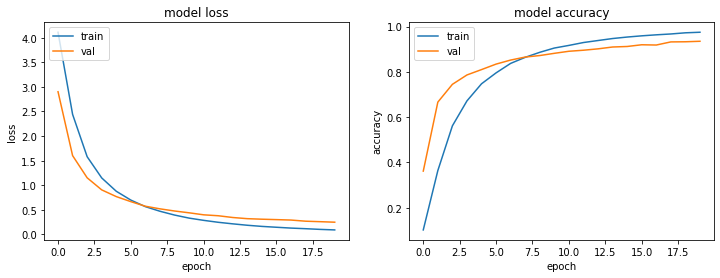

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 304ms/step - loss: 0.2781 - categorical_accuracy: 0.9281


0.928124725818634

### Dropout 0.1

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.1

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_3 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              2409472   
_________________________________________________________________
activation_14 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_15 (Activation)   (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 97s 364ms/step - loss: 4.3760 - categorical_accuracy: 0.0786 - val_loss: 2.3872 - val_categorical_accuracy: 0.5132
Epoch 2/20
265/265 [==============================] - 96s 363ms/step - loss: 2.1311 - categorical_accuracy: 0.4484 - val_loss: 1.3309 - val_categorical_accuracy: 0.7033
Epoch 3/20
265/265 [==============================] - 96s 364ms/step - loss: 1.2337 - categorical_accuracy: 0.6614 - val_loss: 0.9683 - val_categorical_accuracy: 0.7720
Epoch 4/20
265/265 [==============================] - 97s 365ms/step - loss: 0.8249 - categorical_accuracy: 0.7710 - val_loss: 0.7683 - val_categorical_accuracy: 0.8111
Epoch 5/20
265/265 [==============================] - 97s 367ms/step - loss: 0.6054 - categorical_accuracy: 0.8288 - val_loss: 0.6400 - val_categorical_accuracy: 0.8394
Epoch 6/20
265/265 [

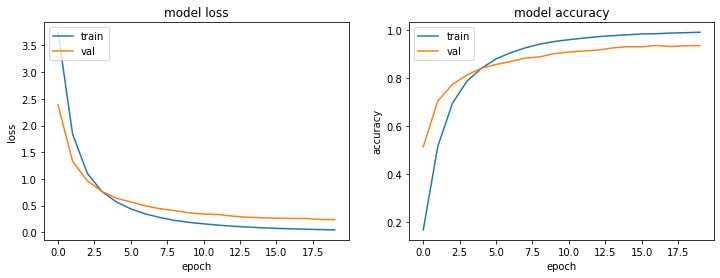

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 14s 305ms/step - loss: 0.2657 - categorical_accuracy: 0.9301


0.9300625324249268

### Dropout 0.05

In [ ]:
init_weights = tf.keras.initializers.GlorotUniform(seed=1234)
activ = 'relu'
p_dropout = 0.05

MyModel = Sequential(
[
    Input(shape = (100, 100, 3)),
    Resizing(28, 28),
    Flatten(),
    Dense(1024, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(512, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(256, kernel_initializer = init_weights),
    Activation(activ),
    Dropout(p_dropout),
    Dense(131, kernel_initializer = init_weights),
    Activation('softmax')
])

MyModel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_4 (Resizing)        (None, 28, 28, 3)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              2409472   
_________________________________________________________________
activation_18 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_19 (Activation)   (None, 512)              

In [ ]:
%%time
sampling = 0
t_split = 0.5
aug = False
epochs = 20
opt = optimizers.Adam(learning_rate = 0.00005)

outputs = FFN(tr_sampling = sampling, test_split = t_split, augmented = aug,
              aug_rot = 45, aug_width = 0.2, aug_height = 0.2, aug_zoom = [0.5, 1.05], 
              aug_horflip = True, aug_verflip = True,
              model_FFN = MyModel, optim = opt, batch = 256, epo = epochs, s = 1)

Found 67692 images belonging to 131 classes.
Found 11335 images belonging to 131 classes.
Found 11353 images belonging to 131 classes.
Epoch 1/20
265/265 [==============================] - 97s 363ms/step - loss: 4.2651 - categorical_accuracy: 0.0985 - val_loss: 2.1822 - val_categorical_accuracy: 0.5352
Epoch 2/20
265/265 [==============================] - 96s 363ms/step - loss: 1.8040 - categorical_accuracy: 0.5464 - val_loss: 1.2248 - val_categorical_accuracy: 0.7281
Epoch 3/20
265/265 [==============================] - 96s 362ms/step - loss: 0.9783 - categorical_accuracy: 0.7408 - val_loss: 0.8999 - val_categorical_accuracy: 0.7795
Epoch 4/20
265/265 [==============================] - 97s 365ms/step - loss: 0.6351 - categorical_accuracy: 0.8279 - val_loss: 0.7106 - val_categorical_accuracy: 0.8278
Epoch 5/20
265/265 [==============================] - 96s 362ms/step - loss: 0.4512 - categorical_accuracy: 0.8768 - val_loss: 0.5831 - val_categorical_accuracy: 0.8536
Epoch 6/20
265/265 [

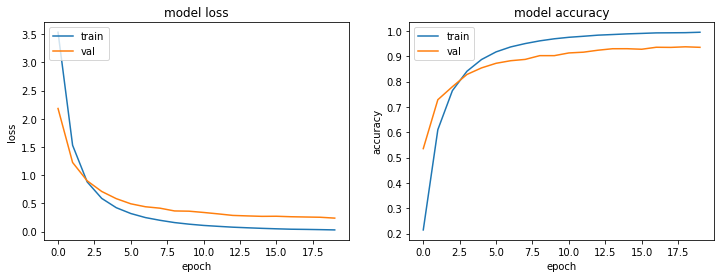

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.set_size_inches(12,4)

ax1.plot(outputs[3].history['loss'])
ax1.plot(outputs[3].history['val_loss'])
ax1.set_title('model loss')
ax1.set(xlabel='epoch', ylabel='loss')
ax1.legend(['train','val'], loc = 'upper left')

ax2.plot(outputs[3].history['categorical_accuracy'])
ax2.plot(outputs[3].history['val_categorical_accuracy'])
ax2.set_title('model accuracy')
ax2.set(xlabel='epoch', ylabel='accuracy')
ax2.legend(['train','val'], loc = 'upper left')
plt.show()

In [ ]:
results_val = MyModel.evaluate(outputs[1])
results_val[1]

results_test = MyModel.evaluate(outputs[2])
results_test[1]

45/45 [==============================] - 13s 299ms/step - loss: 0.2688 - categorical_accuracy: 0.9303


0.9303267598152161

## Plot models

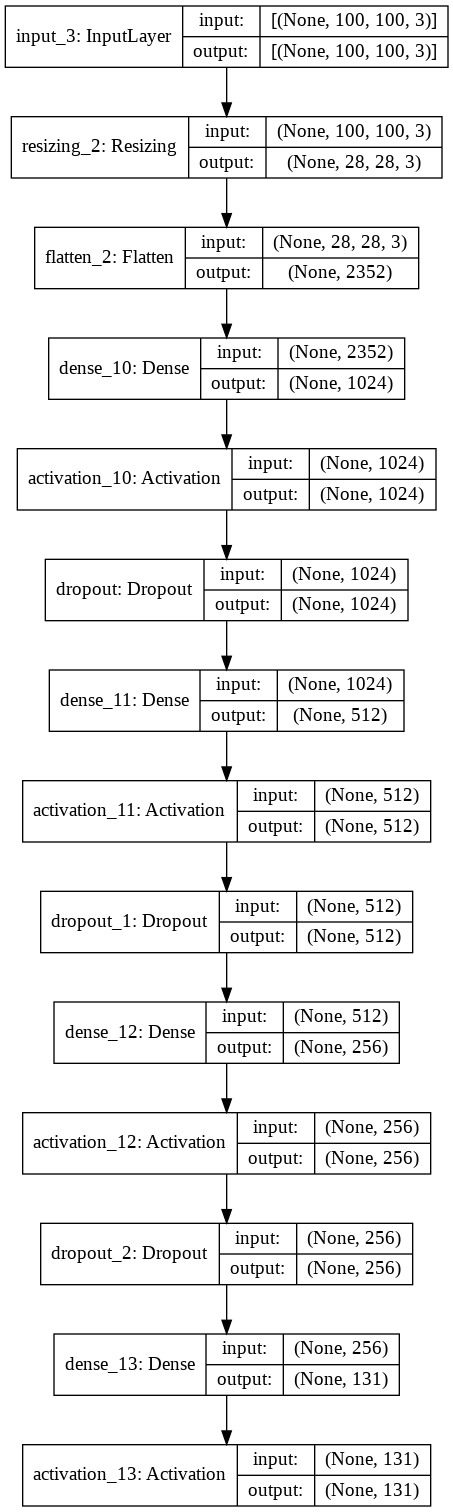

In [ ]:
tf.keras.utils.plot_model(MyModel, to_file='drive/MyDrive/AML-Project/FNN_models/model_3layers_dropout02.png', show_shapes=True)

In [ ]:
import shutil
import os

file_names = os.listdir(multi)
    
for file_name in file_names:
    if file_name.endswith(".jpg"):
      os.makedirs(multi + file_name[:-4], exist_ok=True)
      shutil.move(multi + file_name, multi + file_name[:-4])

In [ ]:
multi_generator = test_processing.flow_from_directory(
        directory = multi,
        color_mode = C,
        batch_size = 32,
        target_size = (H, W),
        class_mode = "categorical",
        shuffle = False,
        seed = 1
        )

In [ ]:
predictions = model.predict(multi_generator)

In [ ]:
for i, image in enumerate(predictions):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
  image_true = load_img('fruits-360/test-multiple_fruits/' + true_label + '/' + true_label + '.jpg')
  ax1.imshow(image_true)
  ax1.grid(False)
  ax2.plot(pred_label)
  plt.show()
  plt.style.use("ggplot")
  plt.plot(image)
  plt.show()
  print("True label:", list(multi_generator.class_indices.keys())[i],
        "\t Best prediction:", list(train_generator.class_indices.keys())[image.argmax()], "\n")
  best_8_indices = image.argpartition(-8)[-8:]
  for j in range(8):
    if image[best_8_indices[j]] > 0.01:
      print("Label: {0:30} Probability {1}".format(list(train_generator.class_indices.keys())[best_8_indices[j]], image[best_8_indices[j]]))

In [ ]:
MyModel.save('drive/MyDrive/AML-Project/FNN_models/aug_model')
MyModel = load_model('path')